# Gravitational Wave Search #

## Functions to be used ##

In [1]:
#import the pycbc specific modules
from pycbc.filter import resample_to_delta_t, matchedfilter, matched_filter
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.waveform import taper_timeseries, get_td_waveform
from pycbc import types, frame

#Import all of the general modules we require
from timeit import timeit, default_timer
from multiprocessing import Pool
from astropy.time import Time
import pandas as pd
import numpy as np
import pylab

#set the environment variable
%env LIGO_DATAFIND_SERVER=ldr.ldas.cit:80

#Define the class that will handle parrallel computing
class ParrallelJobHandler():
    #initialisation
    def __init__(self, processes = 8):
        #define the number of pool workeds this will use
        self.processes = processes
    
    #execute a function with an array of inputs in parrallel
    def runJob(self, function, *inputs, unpack=False):
        funcname = function.__name__
        print()
        #ensure that nested inputs are adequately dealt with
        inputs = expandArray(*inputs, unpack=unpack)
        #create a counter to show how many processes are remaining
        numleft, maxnum = 0, 0
        #create the pool
        with Pool(self.processes) as p:
            #split the inputs among the workers
            r = p.starmap_async(function, inputs)
            #check the job is still running
            while not r.ready():
                #check if a job has been completed
                if (numleft != r._number_left):
                    #update our counter
                    numleft = r._number_left
                    maxnum = max(maxnum, numleft)
                    #show a nice display to the user
                    showProgress(funcname, maxnum - numleft, maxnum)
        showProgress(funcname, maxnum, maxnum, overwrite=False)
        #store the results of the job internally
        self.lastResult = r.get()
        #return the results
        return self.lastResult
    
    #execute a parrallel job, and report the time taken
    def timedJob(self, function, *inputs, unpack=False):
        #create the timeit, and execute
        t = timeit(lambda: self.runJob(function, *inputs, unpack=unpack), number = 1)
        #once complete, show the runtime
        print(" - {} completed in {:.2f}s".format(function.__name__, t))
        #and return the output of the job
        return self.lastResult
    
    #execute a single function and report the time taken
    def timedFunc(self, function, *inputs):
        def execute(self, function, *inputs):
            self.lastResult = function(*inputs)
        #create the timeit, and execute
        t = timeit(lambda: execute(self, function, *inputs), number = 1)
        #once complete, show the runtime
        print(" - {} completed in {:.2f}s".format(function.__name__, t))
        #and return the output of the job
        return self.lastResult

#function that takes a tupple of inputs, and returns an array of unique combinations of the inputs
def expandArray(*inputs, useLCM=True, unpack=False):
    #compute the number of unique values we need based on the lengths of all lists in the inputs
    b = [1, 1] + list([len(x) for x in inputs if isinstance(x, (tuple, list))])
    #compute the total combinations using product or LCM
    if useLCM:
        b = int(np.lcm.reduce(b))
    else:
        b = int(np.product(b))
    
    #create a new array formed of the inputs
    mixed = np.array([[y[x%len(y)] if isinstance(y, (tuple, list)) else y for y in inputs] for x in range(b)], dtype="object")
    #if the array contained additional tupples that need to be unpacked, this will handle them
    mixed = np.array([[z for y in x for z in (y if isinstance(y, (list, tuple)) else (y,))] for x in mixed], dtype="object")
    #try to return the sorted array
    try:
        #sort the array by column
        sort = mixed[np.lexsort(np.transpose(mixed)[::-1])]
    #else just return the mixed
    except:
        sort = mixed
    return [tuple(x) for x in sort]
    
#Function to print a nice loading sequence
def showProgress(operation, current, total, length=100, overwrite=True):
    #ensure the inputs are valid
    if total:
        #convert to a fraction
        progress = max(0, float(current / total))
        #setup the text to print
        done = int(round(progress * length))
        todo = length - done
        text = " - {} \t [{}] {:.1f}%".format(operation, "#"*done + "-"*todo, progress*100)
        #check if we have reached the end of the bar
        if overwrite:
            #print the text as is
            print(text, end="\r")
        else:
            #otherwise print the text without the return sequence
            print(text)

#ensure that data provided is in a plottable format
def toPlottable(data):
    #ensure the data is in a dictionary format
    if not isinstance(data, dict):
        #check if the data is nested timeseries
        if isinstance(data[0], (types.FrequencySeries, types.TimeSeries)):
            #try to fetch plotname from meta data
            try:
                return dict([(x.plotName, x) for x in data])
            #otherwise, give a default name
            except:
                return dict([("Waveform", x) for x in data])
        #if the data is not
        else:
            #try and fetch it's plotname
            try:
                return {data.plotName: data}
            except:
                return {"waveform": data}
    #return the nicely formatted data
    return data

def subPlot(data, title="", xlab="", ylab="", xlim=None, ylim=None, sharex=True, sharey=True, figsize=(10,10),
            grid=True, asLogLog=False, asQTransform=True, notePeak=False, savePlotName="", maxplots=1000):
    #ensure the data provided is acceptable
    data = toPlottable(data)
    maxplots = min(maxplots, len(data))
    
    #fetch the figure and axes
    fig = pylab.figure(figsize=(figsize[0], maxplots*figsize[1]))
    gs = fig.add_gridspec(maxplots, hspace=0)
    axes = gs.subplots(sharex=sharex, sharey=sharey)
    
    #itterate through the dictionary
    y = 0
    for x in data:
        #check if we have a frequency series
        if isinstance(data[x], types.FrequencySeries):
            xplot = data[x].sample_frequencies
            #apply the xlabel if not done so already
            if not xlab:
                xlab = "Frequency (Hz)"
        #else check for timeseries
        elif isinstance(data[x], types.TimeSeries):
            xplot = data[x].sample_times
            if not xlab:
                xlab = "Time (s)"
        
        #check if we are plotting as a Log-Log graph
        if asLogLog:
            axes[y].loglog(xplot, data[x], label=x)
        if asQTransform:
            t, f, p = data[x].whiten(4, 4).qtransform(.001,logfsteps=100,qrange=(8, 8),frange=(10, 512))
            axes[y].pcolormesh(t, f, p**0.5, vmin=1, vmax=6, shading="auto")
            axes[y].set_yscale('log')
            xlab='Time (s)'
            ylab='Frequency (Hz)'
        else:
            axes[y].plot(xplot, data[x], label=x)
        
        #check if we are meant to note the location of the peak on this axis
        if False:#notePeak:
            posx = data[x].numpy().argmax()
            posy = xplot[posx]
            axes[y].text(posx, posy, "{}: {}, {}".format(x, posx, posy), fontsize="small")
        #increment to the next axes
        y = (y+1)%maxplots
    
    #set the title
    axes[0].set_title(title)
    
    #show the plot, and label the outer
    for ax in axes:
        #set the axes labels
        ax.set_xlabel(xlab)
        ax.set_ylabel(ylab)
        #try to add a legend if possible
        try:
            ax.legend(loc="best")
        except:
            pass
        #check limits
        if xlim:
            ax.set_xlim(xlim)
        if ylim:
            ax.set_ylim(ylim)
        #add a grid
        if grid:
            ax.grid()
        #ensure that the labels are only on the outermost
        ax.label_outer()
    
    fig.show()
    
    #if a save name has been supplied
    if savePlotName:
        #remove any fileextensions if given, and add '.png' instead
        savename = "{}.png".format(str(savePlotName).split(".")[0])
        #save the figure
        fig.savefig(savename, bbox_inches='tight')

#plot the data
def plotData(data, title="", xlab="", ylab="", xlim=None, ylim=None, figsize=(10,10),
             grid=True, asLogLog=False, asQTransform=False, notePeak=False, savePlotName=""):
    #create the plot
    fig = pylab.figure(figsize=figsize)
    ax = fig.add_axes((0, 0, 1, 1))
    
    #ensure the data provided is acceptable
    data = toPlottable(data)
    #itterate through the provided data and plot it
    for x in data:
        #check if we have a frequency series
        if isinstance(data[x], types.FrequencySeries):
            xplot = data[x].sample_frequencies
            #apply the xlabel if not done so already
            if not xlab:
                xlab = "Frequency (Hz)"
        #else check for timeseries
        else:
            xplot = data[x].sample_times
            if not xlab:
                xlab = "Time (s)"
        
        #check if we are plotting as a Log-Log graph
        if asLogLog:
            ax.loglog(xplot, data[x], label=x)
        if asQTransform:
            t, f, p = data[x].whiten(4, 4).qtransform(.001,logfsteps=100,qrange=(8, 8),frange=(10, 512))
            ax.pcolormesh(t, f, p**0.5, vmin=1, vmax=6, shading="auto")
            ax.set_yscale('log')
            xlab='Time (s)'
            ylab='Frequency (Hz)'
        else:
            ax.plot(xplot, data[x], label=x)
        
        #check if we are meant to note the location of the peak on this axis
        if notePeak:
            posx = data[x].numpy().argmax()
            posy = xplot[posx]
            ax.text(posx, posy, "{}: {}, {}".format(x, posx, posy), fontsize="small")
    
    #set the title
    ax.set_title(title)
    #set the axes labels
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    #try to add a legend if possible
    try:
        ax.legend(loc="best")
    except:
        pass
    #add a grid
    if grid:
        ax.grid()
    #check limits
    if xlim:
        ax.set_xlim(xlim)
    if ylim:
        ax.set_ylim(ylim)
    #show the plot
    fig.show()
    
    #if a save name has been supplied
    if savePlotName:
        #remove any fileextensions if given, and add '.png' instead
        savename = "{}.png".format(str(savePlotName).split(".")[0])
        #save the figure
        fig.savefig(savename, bbox_inches='tight')


#plot data on a nice pandas dataframe.
def asTable(*inputs, title="", latexName=""):
    #create our dataframe
    df = pd.DataFrame()
    #create some empty arrays that will hold the headers, etc
    headers, titles, units = [], [], []
    #iterate through the supplied inputs to fetch each thing to plot
    for x in range(len(inputs)):
        #ensure we have data in the correct form
        if not (isinstance(inputs[x], dict) and ("data" in inputs[x].keys())):
            #if the input is not a dictionary that contains a data value, then go to the nex input
            continue
        thisdict = inputs[x]
        #if we've been given a header
        headers = np.append(headers, [thisdict["header"] if "header" in thisdict else ""])
        #or a units column
        units = np.append(units, [thisdict["unit"] if "unit" in thisdict else ""])
        #add our title to the title array
        titles = np.append(titles, title)
        #add the data to the table
        try:
            df[x] = thisdict["data"]
        except:
            df[x] = thisdict["data"].flatten()
    #set the column titles
    df.columns = pd.MultiIndex.from_arrays([titles, headers, units], names=[" ", "value", "unit"])
    #ensure we see all rows
    pd.set_option('display.max_rows', None)
    #and show the display
    display(df)
    #if we were given a latex savename
    if latexName:
        #save as a latex table
        df.to_latex("{}.tex".format(latexName.replace(".tex","")))

#function to grab our metadata from an object
def fetchMeta(obj):
    class meta:
        def __init__(self, plotName=None, detectorName=None):
            self.plotName = plotName
            self.detectorName = detectorName
    #return the new metadata only object
    try:
        try:
            return meta(obj.plotName, obj.detectorName)
        except:
            return meta(obj.plotName)
    except:
        return meta()

#function to add metadata to an object
def addMeta(new, old, addtoname=""):
    new.plotName = old.plotName
    new.detectorName = old.detectorName
    if addtoname:
        new.plotName="{} {}".format(new.plotName, addtoname)
    return new

#return the absolute value of a waveform
def toABS(waveform):
    return abs(waveform).astype("complex128")

#convert a time (orarray of times) to UTC string
def toUTC(times):
    #if the times given is not itterable
    if isinstance(times, (str, float, int)):
        try:
            #try to compute the time
            return str(Time(Time(float(times), format="gps"), format="iso", scale="utc"))
        except:
            return times
    #otherwise, assume it is itterable
    return [toUTC(x) for x in times]

#convert a frequencyseries to a time one
def toTime(waveform):
    if not isinstance(waveform, types.TimeSeries):
        meta = fetchMeta(waveform)
        waveform = waveform.to_timeseries()
        return addMeta(waveform, meta)
    return waveform

#convert a time to a freq
def toFreq(waveform):
    if not isinstance(waveform, types.FrequencySeries):
        meta = fetchMeta(waveform)
        waveform = waveform.to_frequencyseries()
        return addMeta(waveform, meta)
    return waveform

#function to normalise a waveform
def normalise(data, psd=None, lowfreq=10):
    #fetch the sigma
    data_sigma = matchedfilter.sigma(data, psd=psd, low_frequency_cutoff=lowfreq)
    #divide the data by the normalisation
    norm = data / data_sigma
    #add the matadata, return it
    return addMeta(norm, data, "normalised")

#compute the signal-to-noise ratio of a template against a data stream
def fetchSNR(template, data, psd=None, lowfreq=10, padding=8):
    #fetch the metadata
    template.detectorName = data.detectorName
    meta = fetchMeta(template)
    #ensure the template is in the time domain (this will be a glitch)
    if not isinstance(template, types.TimeSeries):
        template = template.to_timeseries(data.delta_t)
    #compute the signal-to-noise
    snr = matched_filter(template, data, psd=psd, low_frequency_cutoff=lowfreq)
    #crop out the padding from the snr, and ensure we have the absolute
    snr = abs(snr.crop(padding, padding))
    return addMeta(snr, meta, "SNR")

#search for peaks using a faster method I hope
def searchPeaks(snr, signalThreshold = 8, timeThreshold = 100):
    #convert the snr to a numpy array
    snr = snr.numpy()
    #find all the peaks
    peaks = np.where(snr >= signalThreshold)[0]
    #check we found any peaks
    #we ignore all single index peaks as errors
    if len(peaks) > 1:
        #compute the boundary region around each signal, ensureing we only have unique peaks
        idxs = 1 + np.where(peaks[1:] - peaks[:-1] > timeThreshold)[0]
        idxs = np.unique(np.concatenate(( [peaks[0]], peaks[idxs], [peaks[-1]] )), axis=0)
        #compute the exact location of each peak within the boundaries
        for x in range(len(idxs)-1):
            locations = [int(idxs[x]) + snr[idxs[x] : idxs[x+1]].argmax() for x in range(len(idxs)-1)]
        #and return the locations of the peaks
        return locations
    #return empty if we did not find any
    return []

#search through an array of SNR's, comparing those from different sources to find the one most likely to have caused a signal
def searchEvents(templates, peaks, snr, timeThreshold = 1):
    #an empty array of events
    events = np.zeros((1, 5))
    snrsection = []
    #itterate through all peak times
    for x in range(len(peaks)):
        #fetch the current information
        tempname, snname, pk, sn = templates[x].plotName, snr[x].detectorName, peaks[x], snr[x]
        #find the SNR and exact time for each event, and add it to the events array
        for y in pk:
            #fetch the utc time for this event
            thistime = float(sn.sample_times[y])
            #stack each peak onto the event array
            events = np.vstack(( events, [thistime, toUTC(thistime), float(sn[y]), tempname, snname] ))
            #fetch the SNR around the signal, and append with metadata. also ensure our SNR indices within the bounds of the SNR
            section = sn[max(0, int(y - timeThreshold/sn.delta_t)) : min(int(y + timeThreshold/sn.delta_t), len(sn))]
            snrsection.append(addMeta(section, sn, "around {}".format(thistime)))
    #remove the zeros array we added to the start
    events = np.delete(events, 0, axis=0)
    #fetch the chronological sorting
    sortidx = events[:,0].argsort()
    #and return the array, by sorting in place. Note: The SNR array needs to be sorted slightly differently to preserve the PyCBC-ness of it
    return events[sortidx], [snrsection[x] for x in sortidx]

#a function that will return an array whose contents includes a specified substring
def fetchStringArray(array, string):
    #attempt to find the substring in place
    try:
        return array[np.where(np.char.find(array, string)>=0)[0]]
    except:
        #otherwise, ensure we are searching a string array
        return array[np.where(np.char.find(np.char.array(array), bytes(string, 'utf-8'))>=0)[0]]

#convert an array of raw events into a neatly analysed array of events
#by finding all clusters of merger events that occur within the signal threshold of eachother.
def findClusters(events, timeThreshold=1):
    '''start as:   time, utctime, snr, name, detector
       end as:     event no. time, utctime, snr, name, detector'''
    #create some shorthand for each column index
    cols = 1
    evtcol, timecol, utccol, snrcol, namecol, detcol = np.arange(cols+events.shape[1])
    #create an array of empty columns
    empty_columns = np.full((len(events), cols), "", dtype="object")
    #and add them to our array
    events = np.c_[empty_columns, events]
    summary = np.zeros((1, events.shape[1]))
    #compute the boundary region around each signal
    peaktimes = events[:,cols].astype("float64")
    idxs = 1 + np.where(peaktimes[1:] - peaktimes[:-1] > timeThreshold)[0]
    #add the first and last indices, and invert the order
    idxs = np.concatenate(( [0], idxs, [len(events)] ))[::-1]
    #itterate through the indices
    for x in range(len(idxs)-1):
        #fetch the detections events to compare
        tocompare = events[idxs[x+1]:idxs[x]]
        #seperate them into glitches and mergers
        glitches = fetchStringArray(tocompare, "Glitch")
        mergers = fetchStringArray(tocompare, "Merger")
        
        #if we had a glitch:
        if len(glitches) > 0:
            #the loudest will be first
            loudglitch = glitches[0]
            #unless we have more than one
            if len(glitches) > 1:
                loudglitch = glitches[np.array(glitches[:,snrcol], dtype="float").argmax()]
                #find the merger in the events and add a tag
                events[int(np.where((events == loudglitch).all(axis=1))[0][0])][evtcol] = "Loudest Glitch"
                
        #if we had a merger:
        if len(mergers) > 0:
            #the loudest will be first
            loudmerger = mergers[0]
            #unless we have more than one
            if len(mergers) > 1:
                loudmerger = mergers[np.array(mergers[:,snrcol], dtype="float").argmax()]
                #find the merger in the events and add a tag
                events[int(np.where((events == loudmerger).all(axis=1))[0][0])][evtcol] = "Loudest Merger"
        
        #fetch the loudest event
        loudevent = tocompare[0]
        if len(tocompare) > 1:
            loudevent = tocompare[np.array(tocompare[:,snrcol], dtype="float").argmax()]
        
        #and if we had both a merger and glitch signal
        merge_glitch_ratio, merge_glitch_offset = "", ""
        if len(mergers) and len(glitches):
            merge_glitch_ratio = "G/M Ratio: {}".format(round(float(loudglitch[snrcol]) / float(loudmerger[snrcol]), 3))
            merge_glitch_offset = "G-M Offset: {}s".format(round(float(loudglitch[timecol]) - float(loudmerger[timecol]), 3))
        
        #insert the event analysis if we had more than one event
        if len(tocompare) > 1:
            events = np.insert(events, idxs[x+1], loudevent, axis=0)
            events[idxs[x+1]][timecol] = merge_glitch_ratio
            events[idxs[x+1]][utccol] = merge_glitch_offset
        
        #add the event number to the column
        events[idxs[x+1]][evtcol] = "Event {} - {}".format(len(idxs) - x - 1, loudevent[namecol].split(":")[0])
        #add the detectors to the column (If a singal was seen in multiple detectors, it will be shown here)
        events[idxs[x+1]][detcol] = ", ".join(np.unique(tocompare[:,detcol]))
        #add this event to our summary array
        summary = np.vstack((summary, events[idxs[x+1]]))
        summary[-1][utccol] = loudevent[utccol]
        #if we have only a single value, ensure we don't report GPS time in our G/M Ratio Column
        if len(tocompare)==1:
            summary[-1][timecol] = ""
        #insert an empty space before the summary
        events = np.insert(events, idxs[x+1], np.full(loudevent.shape, "", dtype="object"), axis=0)
    #remove the initial zeros from our summary array
    summary = np.delete(summary, 0, axis=0)[::-1]
    #return the analysed events
    return events, summary

#fetch the spectral density of a waveform
def fetchPSD(data, lowfreq=10, psdtime=4):
    meta = fetchMeta(data)
    #ensure we have a timeseries
    if not isinstance(data, types.TimeSeries):
        data = data.to_timeseries()
    #compute psd
    psd = data.psd(psdtime)
    #interpolate
    psd = interpolate(psd, data.delta_f)
    #now do my favourite function
    psd = inverse_spectrum_truncation(psd, int(data.sample_rate * psdtime), low_frequency_cutoff=lowfreq)
    #apply metadata and return
    return addMeta(psd, meta, "spectral density")

#function to fetch data from a source
def fetchData(name, channel, gps_time, length=8, delta_t=1.0/4096):
    #fetch the data
    ts = frame.query_and_read_frame(name, channel, gps_time, gps_time+length)
    #resample to delta_t
    ts = resample_to_delta_t(ts, delta_t)
    #add our metadata
    ts.plotName="{}, {}".format(name, gps_time)
    ts.detectorName = channel.split(":")[0]
    return ts

#split data into equally spaced subsections
def splitData(data, length=64, padding=8):
    #fetch the metadata
    meta = fetchMeta(data)
    #calculate the number of splitable sections, such that some padding is removed from the end, and each is a defined length
    sections = np.floor((data.duration - 2*padding) / length)
    #convert the time durations to indices
    padding /= data.delta_t
    length /= data.delta_t
    #split the array, with overlapping sections, adding metadata to each
    return [ addMeta(data[int(x * length) : int((x+1) * length + 2 * padding)], meta, "+{}s".format(x*length*data.delta_t)) for x in range(int(sections)) ]

#combine two operations into a single function call
def fetchSplitData(name, channel, gps_time, chunks=1, sublength=128, padding=8, delta_t=1.0/4096):
    #fetch the data
    data = fetchData(name, channel, gps_time, chunks*sublength + 2*padding, delta_t)
    #and return the split data
    return splitData(data, sublength, padding)
    
#create a merger using PyCBC
def createMerger(mass1, mass2, distance=100, delta_t=1.0/4096, tlen=None, lowfreq=10, approximant="SEOBNRv4_opt"):
    #create the waveform
    waveform = get_td_waveform(approximant=approximant, mass1=mass1, mass2=mass2,
                               delta_t=delta_t, f_lower=lowfreq, distance=distance)[0]
    #taper the waveform
    waveform = taper_timeseries(waveform, "TAPER_START")
    #resize the template if neccesary
    if tlen:
        waveform.resize(int(tlen / delta_t))
        #shift the data so that the strongest point occurs at t=0
        waveform = waveform.cyclic_time_shift(waveform.start_time)
    #add our metadata
    waveform.plotName="Merger: {}, {}".format(mass1, mass2)
    #return the merger
    return waveform

#create a glitch using our model
def createGlitch(mass1, mass2, distance=100, delta_t=1.0/4096, tlen=None, lowfreq=10, approximant="SEOBNRv4_opt"):
    #create the waveform
    waveform = get_td_waveform(approximant=approximant, mass1=mass1, mass2=mass2, delta_t=delta_t, f_lower=lowfreq, distance=distance)[0]
    #taper the waveform
    waveform = taper_timeseries(waveform, "TAPER_START")
    #resize the template if neccesary
    if tlen:
        waveform.resize(int(tlen / delta_t))
        #shift the data so that the strongest point occurs at t=0
        waveform = waveform.cyclic_time_shift(waveform.start_time)
    #convert the waveform to a glitch by taking the absolute
    waveform = toABS(waveform.to_frequencyseries())
    #add our metadata
    waveform.plotName="Glitch: {}, {}".format(mass1, mass2)
    #return the merger
    return waveform

env: LIGO_DATAFIND_SERVER=ldr.ldas.cit:80


# The Search #

## Setup Constants ##

In [2]:
#initialise our parrallel job handler
job = ParrallelJobHandler(10)

#fetch the detector and gpstime
channel = "L1:GDS-CALIB_STRAIN"
frametype = "L1_HOFT_C00"
gps_time = 1242442818
#Current test period: 1250553618
#Start of 2019-05-21 1242432018
#IMBH check time: 1242442818
#Initial testing time: 1244473218
delta_t = 1.0/4096

#1242442818 GPS TIME CONTAINS GW190521, so hopefully it will trigger the detection

#setup the length values for each item
chunks = 24 # 24 = 3hrs
padding = 32
sublength = 512
#16 * 512 ~= 2 hours of data

## Fetch Data ##

Fetching L1 Data
Fetching H1 Data
fetching spectral density

 - fetchPSD 	 [####################################################################################################] 100.0%
 - fetchPSD completed in 20.46s
Showing Spectral density


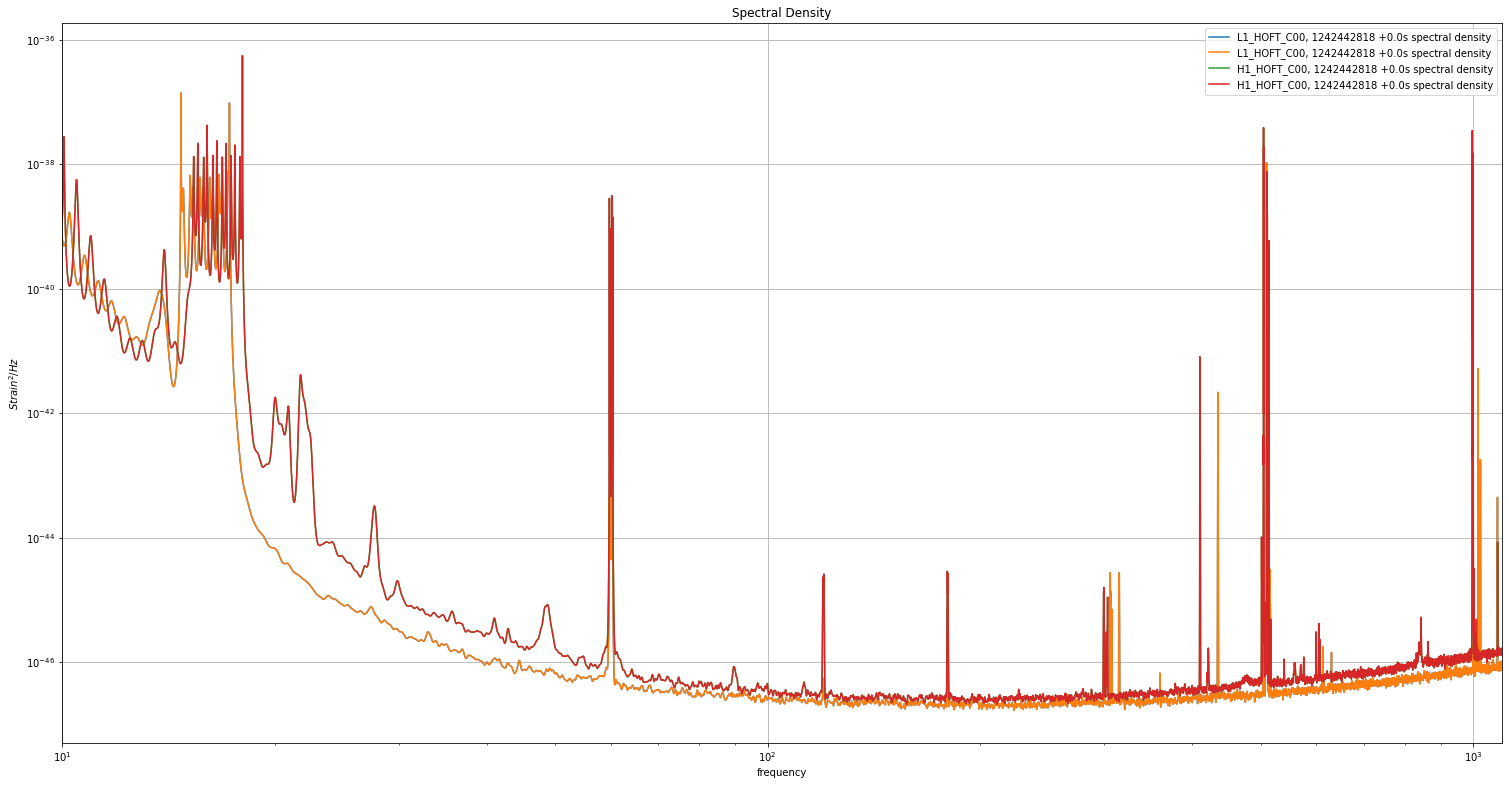

In [3]:
#fetch the data
print("Fetching L1 Data")
dataArray = fetchSplitData(frametype, channel, gps_time, chunks, sublength, padding, delta_t)
print("Fetching H1 Data")
dataArray += fetchSplitData(frametype.replace("L1", "H1"), channel.replace("L1", "H1"), gps_time, chunks, sublength, padding, delta_t)

#show an example of the data split
#print("Showing data")
#subPlot(dataArray, figsize=(20, 3), title="Data split into smaller chunks", maxplots=2, grid=True)

#fetch the spectral density of each section of data
print("fetching spectral density")
psdArray = job.timedJob(fetchPSD, dataArray, 10, 4)

#show an example of the spectral density
print("Showing Spectral density")
plotData([psdArray[0], psdArray[chunks]], xlim=(10, 1100), figsize=(20, 10), xlab="frequency", ylab='$Strain^2 / Hz$', title="Spectral Density", asLogLog=True)

## Create Merger templates for the search ##

Creating Merger Templates

 - createMerger 	 [####################################################################################################] 100.0%
 - createMerger completed in 8.14s
Plotting Example Mergers


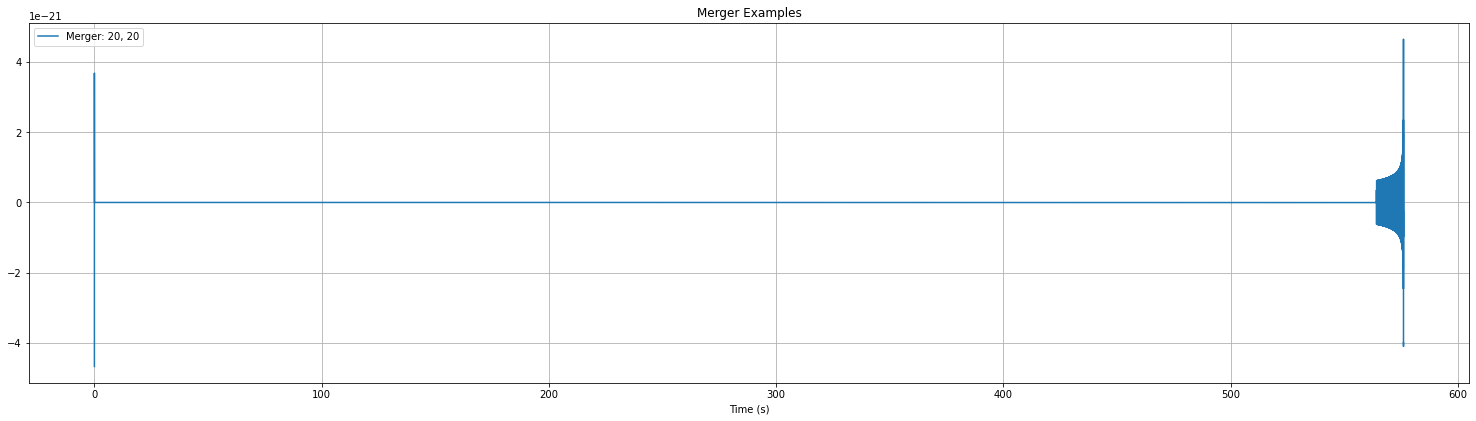

In [4]:
print("Creating Merger Templates")
#create an array of mass pairs for the merger templates
minmass = 20
maxmass = 300
massstep = 10

#create an array of mass pairs for the templates
massArray = [(x, x) for x in np.arange(minmass, maxmass+massstep, massstep)]

#the length of each template should match our data chunk, with some padding
template_length = dataArray[0].duration

#compute the set of mergers
mergers = job.timedJob(createMerger, massArray, 100, delta_t, template_length, unpack=True)

#and plot them to show everything works in order
print("Plotting Example Mergers")
plotData(mergers[0], title="Merger Examples", figsize=(20, 5))

## Create Glitch templates for the search ##

Creating Glitch Templates

 - createGlitch 	 [####################################################################################################] 100.0%
 - createGlitch completed in 10.46s
Plotting Example Glitches


/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py38/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


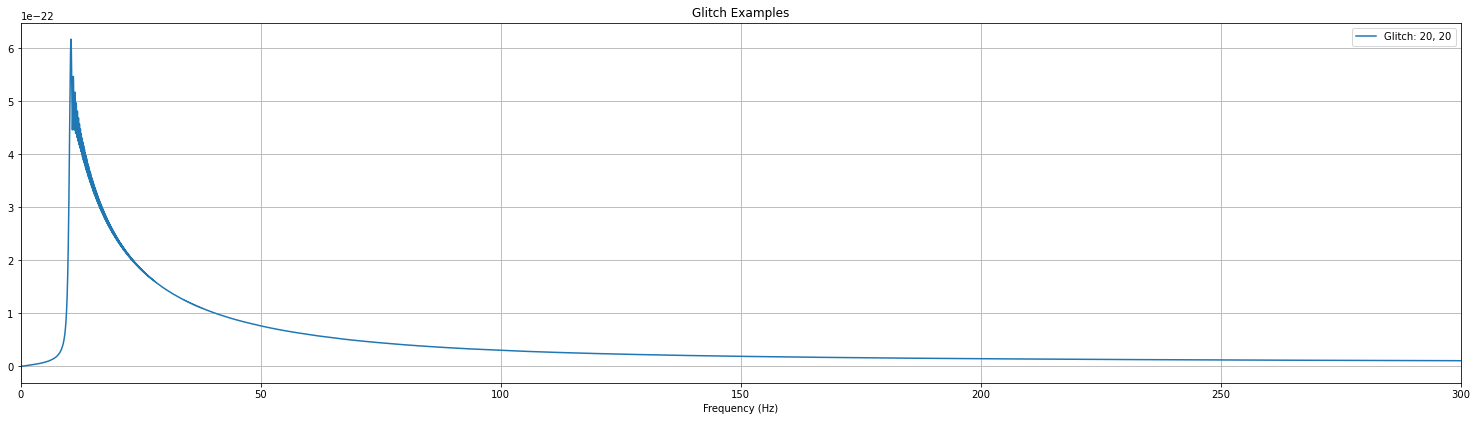

In [5]:
#create an array of mass pairs for the glitches
print("Creating Glitch Templates")
#create an array of mass pairs for the merger templates
Gminmass = 20
Gmaxmass = 300
Gmassstep = 10

#create an array of mass pairs for the templates
GmassArray = [(x, x) for x in np.arange(Gminmass, Gmaxmass+Gmassstep, Gmassstep)]

#compute a set of viable glitches (50, 50) responds best to known glitch events
glitches = job.timedJob(createGlitch, GmassArray, 100, delta_t, template_length)

#and plot them to show everything works in order
print("Plotting Example Glitches")
plotData(glitches[0], title="Glitch Examples", figsize=(20, 5), xlim=(0, 300))

## Compute the SNR for each data chunk ##

In [6]:
#compile the template events into an array
templates = glitches+mergers

#setup the constants for the functions
lowfreq = 10
signalThreshold = 7  # The SNR must be above this value to count
timeThreshold = 5    # Two SNR peaks must be at least this far apart (in seconds) to count

#start out our events array with a run of zeros. We will have to remove this afterwards.
events = np.zeros((1, 5))

for x in range(len(dataArray)):
    #fetch the current chunks of data
    dataChunk, psdChunk = dataArray[x], psdArray[x]
    print("Searching: {}".format(dataChunk.plotName))
    #Load from save file
    try:
        evts = np.load("savedData/{}.npy".format(dataChunk.plotName))
        print("\n - Loading SNRs")
        events = np.vstack((events, evts))
    #otherwise, compute as neccesary
    except:
        print("\n - Computing SNRs")
        #compute the SNR for each template
        SNRs = job.timedJob(fetchSNR, templates, dataChunk, psdChunk, lowfreq, padding)

        print("\n - Finding Peaks")
        #find all of the peaks in the SNR
        peaks = job.timedJob(searchPeaks, SNRs, signalThreshold, timeThreshold / delta_t)

        #plotData(SNRs, title="{} - SNR".format(dataChunk.plotName))
        print("\n - Compiling Probable Events")
        #fetch the events within our timeThreshold
        evts = job.timedFunc(searchEvents, templates, peaks, SNRs, timeThreshold)[0]
        #save this data for future usage
        np.save("savedData/{}.npy".format(dataChunk.plotName), evts)
        #concatenate with the previously found events
        events = np.vstack((events, evts))
    
    #print a small newline seperator to separate the outputs slightly
    print("\n\n")
    
    SNRs, peaks = None, None

#remove the run of zeros we started with
events = np.delete(events, 0, axis=0)

# We don't have to sort the data normally, but if we are splicing data between multiple detectors, this is neccesary
if len(dataArray) > chunks:
    #(if we have more data points than we should if we only queried one detector)
    sortidx = events[:,0].argsort()
    #sort using the sorting index found above
    events = events[sortidx]
    #waves = [waves[x] for x in sortidx]

#Latex name stuff
dateTime = toUTC(gps_time).split(" ")[0][2:].replace("-","")
timeLen = "{}hr".format(int(np.floor((chunks*sublength) / 3600)))

#Save the events array for later use if neccesary
np.save("{}-{}-events.npy".format(dateTime, timeLen), events)

Searching: L1_HOFT_C00, 1242442818 +0.0s

 - Loading SNRs



Searching: L1_HOFT_C00, 1242442818 +512.0s

 - Loading SNRs



Searching: L1_HOFT_C00, 1242442818 +1024.0s

 - Loading SNRs



Searching: L1_HOFT_C00, 1242442818 +1536.0s

 - Loading SNRs



Searching: L1_HOFT_C00, 1242442818 +2048.0s

 - Loading SNRs



Searching: L1_HOFT_C00, 1242442818 +2560.0s

 - Loading SNRs



Searching: L1_HOFT_C00, 1242442818 +3072.0s

 - Loading SNRs



Searching: L1_HOFT_C00, 1242442818 +3584.0s

 - Loading SNRs



Searching: L1_HOFT_C00, 1242442818 +4096.0s

 - Loading SNRs



Searching: L1_HOFT_C00, 1242442818 +4608.0s

 - Loading SNRs



Searching: L1_HOFT_C00, 1242442818 +5120.0s

 - Loading SNRs



Searching: L1_HOFT_C00, 1242442818 +5632.0s

 - Loading SNRs



Searching: L1_HOFT_C00, 1242442818 +6144.0s

 - Loading SNRs



Searching: L1_HOFT_C00, 1242442818 +6656.0s

 - Loading SNRs



Searching: L1_HOFT_C00, 1242442818 +7168.0s

 - Loading SNRs



Searching: L1_HOFT_C00, 1242442818 +7680.0s


## Show our results in a nice table ##

In [7]:
#fetch the times for the title
start_time = gps_time + padding
end_time = start_time + chunks*sublength
#search through the events to find overlaping times
analysed_events, summarised_events = findClusters(events, timeThreshold)


#Latex name stuff
'''runNo = 2
dateTime = toUTC(gps_time).split(" ")[0][2:].replace("-","")
timeLen = "{}hr".format(int(np.floor((chunks*sublength) / 3600)))'''


#split the summary array into a few subarrays
evtnum, gmratio, utcTime, value, names, detector = np.hsplit(summarised_events, 6)
#show the summary data on a table
asTable({"header":"Event", "unit":"", "data":evtnum},
        {"header":"Detector", "unit":"", "data":detector},
        {"header":"Tempate name", "unit":"", "data":names},
        {"header":"G/M Ratio", "unit":"", "data":gmratio},
        {"header":"UTC Time", "unit":"ISO string", "data":utcTime},
        {"header":"Signal SNR", "unit":"#", "data":value},
        title="Summary of Gravitational Signals between {} and {}, Signal Threshold SNR >= {}".format(toUTC(start_time), toUTC(end_time), float(signalThreshold)),
        latexName="{}-{}-Summary_TimeSorted".format(dateTime, timeLen))


#split the summary array into a few subarrays, sorted by SNR
evtnum, gmratio, utcTime, value, names, detector = np.hsplit(summarised_events[summarised_events[:,3].astype("float64").argsort()], 6)
#show the summary data on a table
asTable({"header":"Event", "unit":"", "data":evtnum},
        {"header":"Detector", "unit":"", "data":detector},
        {"header":"Tempate name", "unit":"", "data":names},
        {"header":"G/M Ratio", "unit":"", "data":gmratio},
        {"header":"UTC Time", "unit":"ISO string", "data":utcTime},
        {"header":"Signal SNR", "unit":"#", "data":value},
        title="Summary of Gravitational Signals between {} and {}, Signal Threshold SNR >= {}".format(toUTC(start_time), toUTC(end_time), float(signalThreshold)),
        latexName="{}-{}-Summary_SNRSorted".format(dateTime, timeLen))


#split the events array into a few subarrays
evtnum, time, utcTime, value, names, detector = np.hsplit(analysed_events, 6)
#show the extended data on a table
asTable({"header":"Event", "unit":"", "data":evtnum},
        {"header":"Detector", "unit":"", "data":detector},
        {"header":"Tempate name", "unit":"", "data":names},
        {"header":"GPS Time", "unit":"Time", "data":time},
        {"header":"UTC Time", "unit":"ISO string", "data":utcTime},
        {"header":"Signal SNR", "unit":"#", "data":value},
        title="Extended view of Gravitational Signals between {} and {}, Signal Threshold SNR >= {}".format(toUTC(start_time), toUTC(end_time), float(signalThreshold)),
        latexName="{}-{}-Full_Results".format(dateTime, timeLen))

Summary of Gravitational Signals between 2019-05-21 03:00:32.000 and 2019-05-21 06:25:20.000, Signal Threshold SNR >= 7.0  \
value                                                                                                                     Event   
unit                                                                                                                              
0                                       Event 1 - Merger                                                                          
1                                       Event 2 - Glitch                                                                          
2                                       Event 3 - Glitch                                                                          
3                                       Event 4 - Glitch                                                                          
4                                       Event 5 - Glitch                                                                          
5                                       Event 6 - Glitch                                                                          
6                                       Event 7 - Glitch                                                                          
7                                       Event 8 - Glitch                                                                          
8                                       Event 9 - Glitch                                                                          
9                                      Event 10 - Glitch                                                                          
10                                     Event 11 - Glitch                                                                          
11                                     Event 12 - Glitch                                                                          
12                                     Event 13 - Merger                                                                          
13                                     Event 14 - Glitch                                                                          
14                                     Event 15 - Glitch                                                                          
15                                     Event 16 - Glitch                                                                          
16                                     Event 17 - Glitch                                                                          
17                                     Event 18 - Glitch                                                                          
18                                     Event 19 - Glitch                                                                          
19                                     Event 20 - Glitch                                                                          
20                                     Event 21 - Glitch                                                                          
21                                     Event 22 - Glitch                                                                          
22                                     Event 23 - Glitch                                                                          
23                                     Event 24 - Glitch                                                                          
24                                     Event 25 - Glitch                                                                          
25                                     Event 26 - Glitch                                                                          
26                                     Event 27 - Glitch                                                                          
27                                     Event 28 - Glitch                    

Summary of Gravitational Signals between 2019-05-21 03:00:32.000 and 2019-05-21 06:25:20.000, Signal Threshold SNR >= 7.0  \
value                                                                                                                     Event   
unit                                                                                                                              
0                                      Event 18 - Glitch                                                                          
1                                       Event 3 - Glitch                                                                          
2                                      Event 20 - Glitch                                                                          
3                                      Event 17 - Glitch                                                                          
4                                      Event 52 - Glitch                                                                          
5                                      Event 36 - Glitch                                                                          
6                                      Event 48 - Glitch                                                                          
7                                       Event 6 - Glitch                                                                          
8                                      Event 30 - Glitch                                                                          
9                                      Event 15 - Glitch                                                                          
10                                     Event 59 - Glitch                                                                          
11                                     Event 51 - Glitch                                                                          
12                                     Event 23 - Glitch                                                                          
13                                     Event 45 - Glitch                                                                          
14                                     Event 57 - Glitch                                                                          
15                                     Event 13 - Merger                                                                          
16                                     Event 38 - Glitch                                                                          
17                                     Event 14 - Glitch                                                                          
18                                     Event 37 - Glitch                                                                          
19                                      Event 2 - Glitch                                                                          
20                                     Event 58 - Glitch                                                                          
21                                     Event 53 - Glitch                                                                          
22                                      Event 5 - Glitch                                                                          
23                                      Event 8 - Glitch                                                                          
24                                      Event 1 - Merger                                                                          
25                                     Event 40 - Glitch                                                                          
26                                     Event 25 - Glitch                                                                          
27                                     Event 12 - Glitch                    

Extended view of Gravitational Signals between 2019-05-21 03:00:32.000 and 2019-05-21 06:25:20.000, Signal Threshold SNR >= 7.0  \
value                                                                                                                           Event   
unit                                                                                                                                    
0                                                                                                                                       
1                                       Event 1 - Merger                                                                                
2                                                                                                                                       
3                                                                                                                                       
4                                                                                                                                       
5                                                                                                                                       
6                                                                                                                                       
7                                                                                                                                       
8                                                                                                                                       
9                                                                                                                                       
10                                                                                                                                      
11                                                                                                                                      
12                                        Loudest Merger                                                                                
13                                                                                                                                      
14                                                                                                                                      
15                                                                                                                                      
16                                                                                                                                      
17                                                                                                                                      
18                                                                                                                                      
19                                                                                                                                      
20                                        Loudest Glitch                                                                                
21                                                                                                                                      
22                                                                                                                                      
23                                                                                                                                      
24                                                                                                                                      
25                                                                                                                                      
26                               

# Extra code, not part of the search #

## Compute Epsilon for things ##

In [ ]:
from pycbc.filter import match
print(dataArray[0])

tdif = (1242442967.4316406 - gps_time)
chk = int(np.floor((tdif - padding) / sublength))
idx = int((tdif - chk * sublength) / delta_t)

print(tdif)
print(idx)
print(chk)

templen = 8

thisdata = dataArray[chk][int(idx - 0.5*templen/delta_t) : int(idx + 0.5*templen/delta_t)]
thisGWEvent = createMerger(96.3, 69, tlen=templen)
thisglitch = createGlitch(130, 130, tlen=templen)
thismerger = createMerger(130, 130, tlen=templen)

plotData(thisdata)

print("Raw data match")
print(match(thisdata, thisglitch))
print(match(thisdata, thismerger))

print("Idealised Merger match")
print(match(thisGWEvent, thisglitch))
print(match(thisGWEvent, thismerger))

## Create Graphs for the report ##

In [ ]:
print("fetch data 1")
datArr1 = fetchData("L1_HOFT_C00", "L1:GDS-CALIB_STRAIN", 1242442818, 512 * 8 + 2 * 32, delta_t=1.0/4096)
print("fetch data 2")
datArr2 = fetchData("H1_HOFT_C00", "H1:GDS-CALIB_STRAIN", 1242442818, 512 * 8 + 2 * 32, delta_t=1.0/4096)

plotData({"L1":datArr1, "H1":datArr2}, figsize=(20, 10), ylab="Strain", title="Data including GW190521 to search", savePlotName="SearchData")

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py38/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py38/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


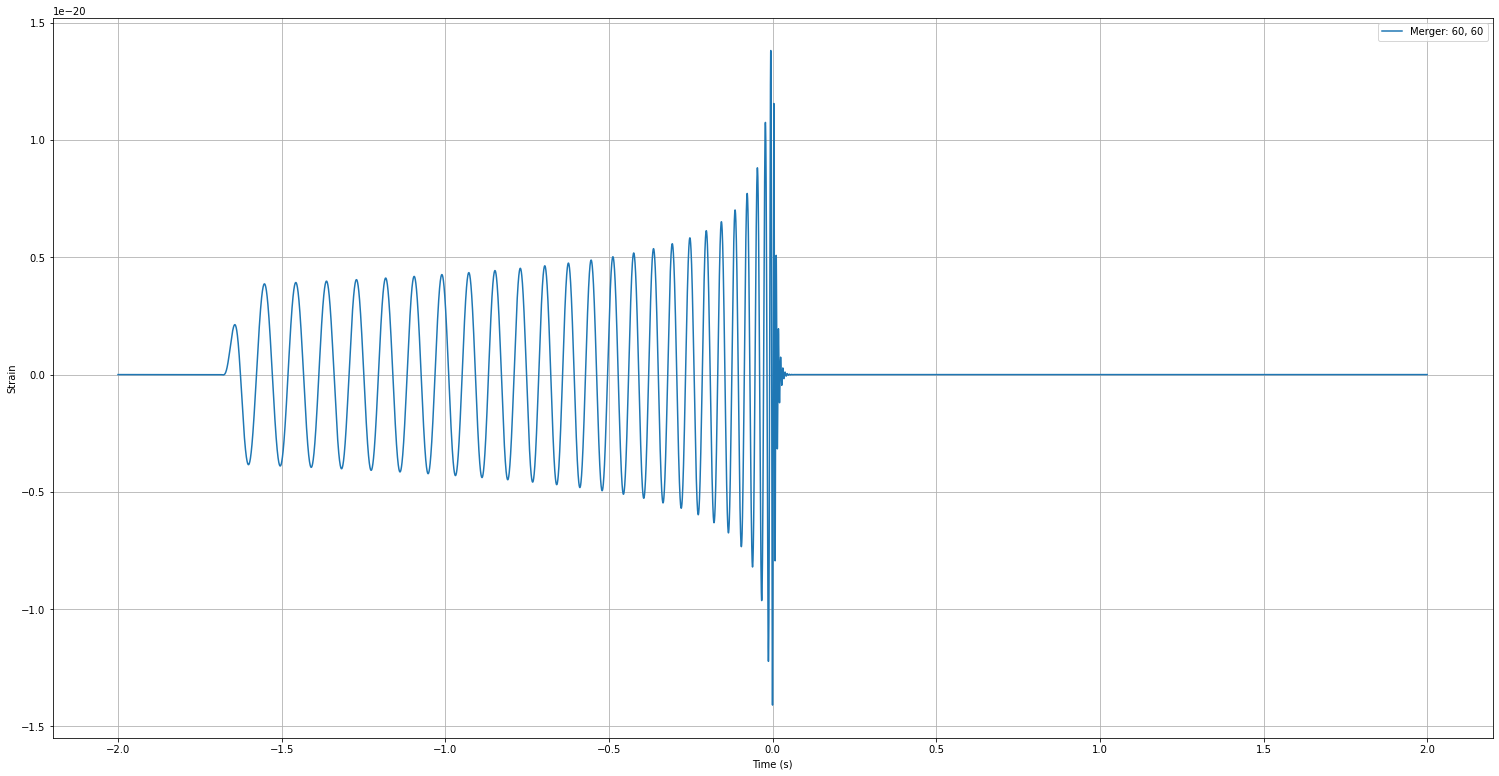

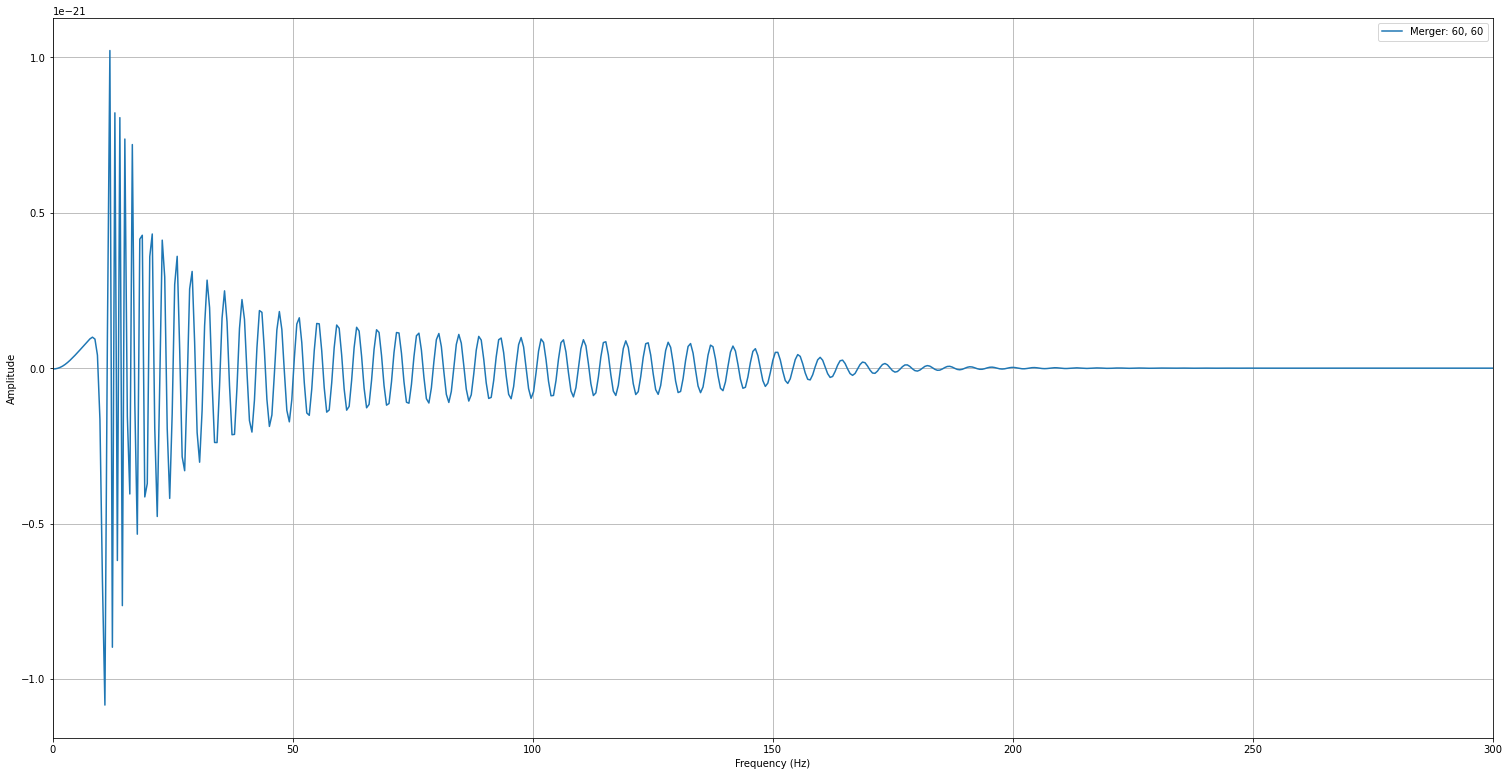

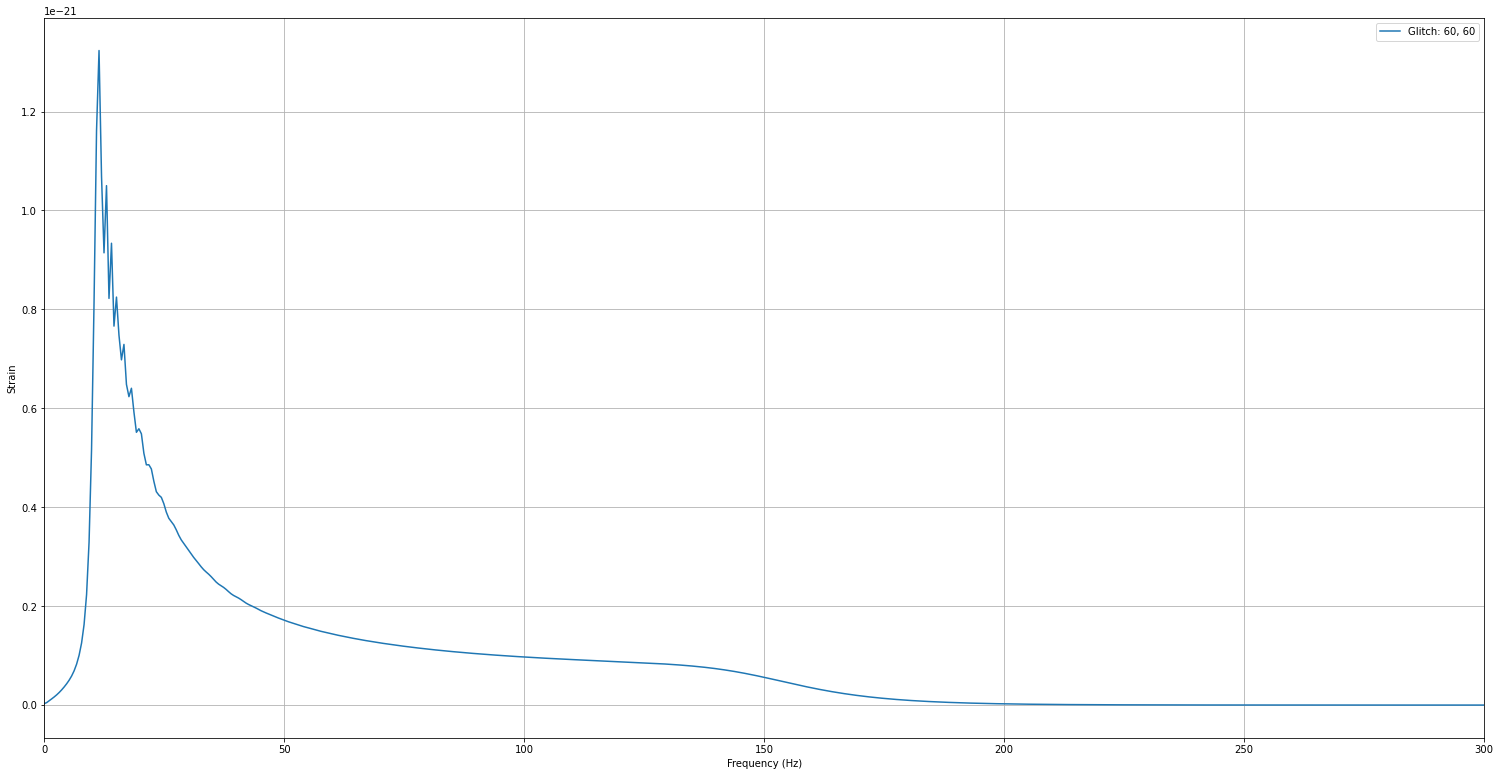

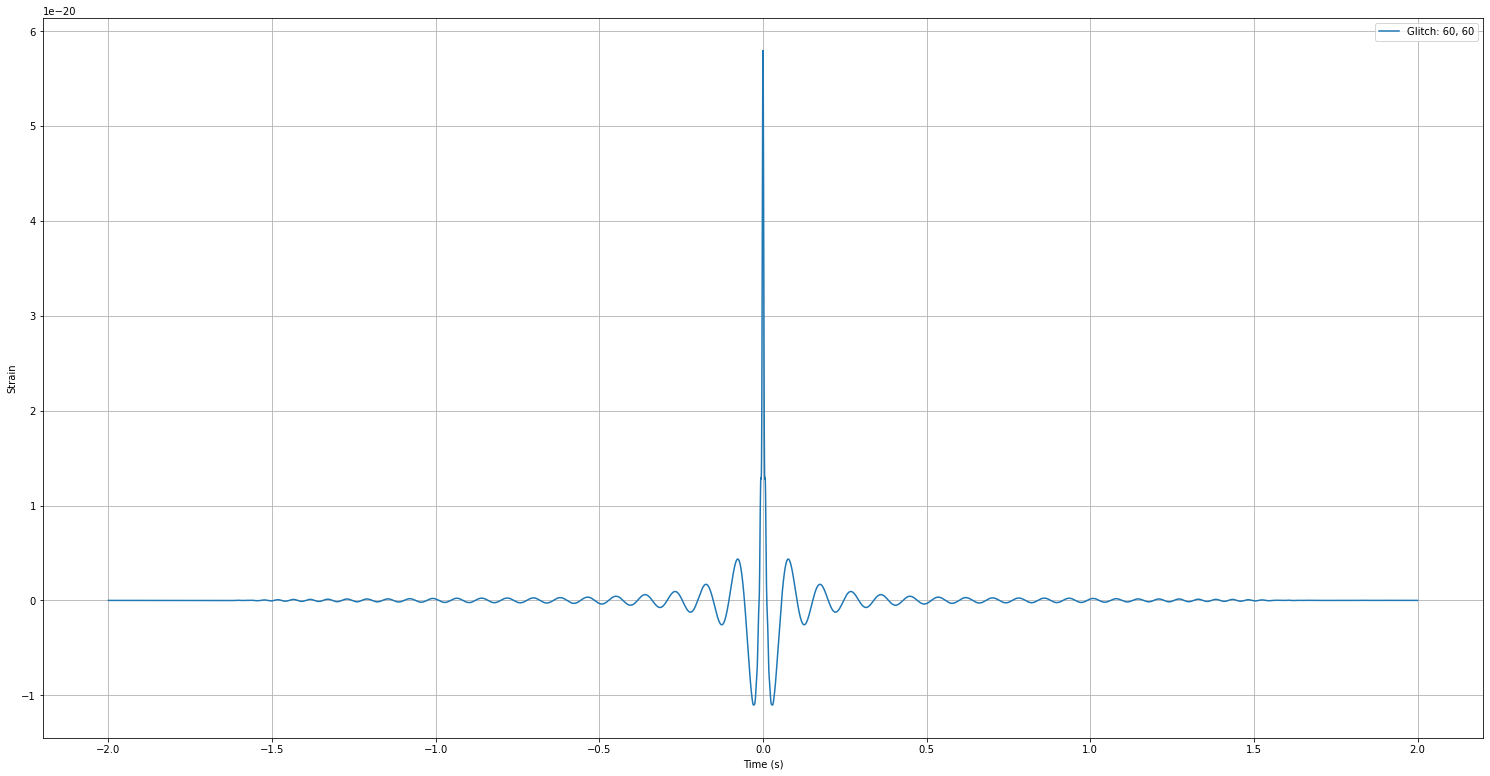

In [5]:
a = createMerger(60, 60, tlen=4)
plotData({a.plotName:a.cyclic_time_shift(2)}, ylab="Strain", figsize=(20, 10), savePlotName="Images/60 merger")
plotData(toFreq(createMerger(60, 60)), ylab="Amplitude", figsize=(20, 10), xlim=(0, 300), savePlotName="Images/60 merger (freq)")

b = createGlitch(60, 60, tlen=4)
plotData(createGlitch(60, 60), ylab="Strain", figsize=(20, 10), xlim=(0, 300), savePlotName="Images/60 glitch")
plotData({b.plotName:toTime(b).cyclic_time_shift(2)}, ylab="Strain", figsize=(20, 10), savePlotName="Images/60 glitch (time)")

## Create a GIF that shows the argument of a Merger collapsing to form a Glitch ##

In [ ]:
from PIL import Image
import glob, re

'''
#create a merger
thismerger = toFreq(createMerger(60, 60, tlen=4))

#define the steps
step = .01
steps = np.arange(0, 1+step, step)[::-1]
#generate each graph
for x in range(len(steps)):
    #fetch a ratio between 1 and 0 as defined by our interpolation
    ratio = steps[x]
    #compute the new merger, by multiplying the phase of the original merger by our ratio
    middlemerger = toTime(np.absolute(thismerger) * np.exp(1j * ratio*np.angle(thismerger)))
    #and plot that new merger, ensureing the peak is in the centre of the graph
    plotData(middlemerger.cyclic_time_shift(2), ylab="Strain", title="Merger to Glitch Conversion", figsize=(15, 8), ylim=(-2E-20, 7E-20), savePlotName="Animation/{}.png".format(x))
'''
# Create the frames
frames = []
imgs = glob.glob("Animation/*.png")
imgs = sorted(imgs, key=lambda x:float(re.findall("(\d+)",x)[0]))
#itterate through the frames
for i in imgs:
    new_frame = Image.open(i)
    frames.append(new_frame)

# Save into a GIF file that loops forever
frames[0].save('png_to_gif.gif', format='GIF', append_images=frames[1:], save_all=True, fps=60, loop=0)